# E-commerce - Выявление профилей потребления

Ссылка на презентацию: https://drive.google.com/file/d/1wi4YLcGtXS4ALnrMr5H-Abu51DbnhNeQ/view?usp=sharing

Задача: 
    
Сегментировать покупателей по профилю потребления 

Датасет содержит информацию о транзакциях интернет-магазина товаров для дома и быта (дата заказа, индентификатор покупателя, идентификатор заказа, наименование, количество и цена товара). На основе истории покупок нужно по каким-то признакам сегментировать покупателей - сегментация должна помочь сформировать для них персонализированные предложения.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing

import re

from scipy import stats as st
from scipy.stats import ttest_ind  

import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

from io import BytesIO
import requests

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных, изучение общей информации и предобработка

In [2]:
spreadsheet_id = '1_IYJQNU4NJhQ4UKhgsTz9VtoiPSoStkGsMFr5o2Pl4U'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112


In [3]:
df['product'] = df['product'].str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         6737 non-null   int64 
 1   customer_id  6737 non-null   object
 2   order_id     6737 non-null   int64 
 3   product      6737 non-null   object
 4   quantity     6737 non-null   int64 
 5   price        6737 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 315.9+ KB


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df.dtypes

date           datetime64[ns]
customer_id            object
order_id                int64
product                object
quantity                int64
price                   int64
dtype: object

In [6]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112


In [7]:
#на всякий случай добавим отдельные столбцы с временем и днём недели, которые могут пригодиться для сегментации
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.dayofweek

In [8]:
df.duplicated().sum()

0

Пропуски и явные дубликаты в данных отсутствуют, но было обнаружено несколько дублирующихся заказов, которые отличаются только по id заказа, а id клиента, время и состав заказа идентичны. Попробуем найти соответствующие строки.

In [9]:
df[df.duplicated(keep=False, subset=['customer_id', 'date', 'quantity', 'product', 'price'])]

,date,customer_id,order_id,product,quantity,price,hour,weekday
1055,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69175,салатник воларэ блэк 16 см g9403 luminarc,6,97,15,6
1056,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69175,тарелка суповая воларэ блэк 23 см g9402 luminarc,3,127,15,6
1057,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69176,салатник воларэ блэк 16 см g9403 luminarc,6,97,15,6
1058,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69176,тарелка суповая воларэ блэк 23 см g9402 luminarc,3,127,15,6
1105,2018-12-04 19:00:00,b2da4ddc-71b5-499b-9806-d59c7a7e6cf5,69207,чайник электрический василиса т33-2000 нержаве...,1,749,19,1
1106,2018-12-04 19:00:00,b2da4ddc-71b5-499b-9806-d59c7a7e6cf5,69208,чайник электрический василиса т33-2000 нержаве...,1,749,19,1
1486,2019-01-12 11:00:00,364754b9-56fd-49b5-b6fb-d1fca7ca82f9,69795,гладильная доска ника lora fashion hlf 123х46 см,1,1912,11,5
1487,2019-01-12 11:00:00,364754b9-56fd-49b5-b6fb-d1fca7ca82f9,69796,гладильная доска ника lora fashion hlf 123х46 см,1,1912,11,5
1526,2019-01-16 15:00:00,fb2f95f0-1f30-4e6a-a75c-92d1e2d341e3,69850,"сушилка для белья на батарею, сб5-45, ника",1,134,15,2
1527,2019-01-16 15:00:00,fb2f95f0-1f30-4e6a-a75c-92d1e2d341e3,69851,"сушилка для белья на батарею, сб5-45, ника",1,134,15,2


In [10]:
data = df.drop_duplicates(subset=['customer_id', 'date', 'quantity', 'product', 'price'], keep='first')
data.shape

(6719, 8)

In [11]:
print('Доля дублирующихся заказов от всего датасета', data.shape[0]/df.shape[0])

Доля дублирующихся заказов от всего датасета 0.9973281876206026


Таких заказов немного, меньше 1%, в принципе, это могут быть и реальные заказы, например, человек купил ведро и тут же вернулся за ещё одним, но можно их и отбросить. 

In [12]:
data[data.duplicated(subset=['customer_id', 'order_id', 'quantity', 'product', 'price'], keep='first')]

,date,customer_id,order_id,product,quantity,price,hour,weekday
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,18,1
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,19,1
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,20,1
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,доска гладильная eurogold professional 130х48 ...,1,3299,4,2
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,эвкалипт гунни d-17 см h-60 см,1,1409,13,3
...,...,...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,сумка-тележка 2-х колесная gimi argo красная,1,1087,10,0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,мирт d-9 см h-15 см,1,134,21,0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397,0,3
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"таз пластмассовый со стиральной доской (иж), 1...",1,397,2,3


In [13]:
data.duplicated(subset=['customer_id', 'order_id', 'quantity', 'product', 'price'], keep='first').sum()/data.shape[0]

0.27742223545170414

In [14]:
data = data.drop_duplicates(subset=['customer_id', 'order_id', 'quantity', 'product', 'price'], keep=False)
print("Количество строк в очищенном датасете", data.shape[0])

order_count = data.groupby('order_id')
print("Количество заказов в очищенном датасете", len(order_count))

Количество строк в очищенном датасете 4350
Количество заказов в очищенном датасете 2533


Но есть также абсолютно идентичные заказы, которые отличаются только датой и временем, например, сделаны с разницей в несколько часов, и это больше четверти строк от всего датасета. Можно предположить, что неправильно реализована система записи данных о заказах. Эти данные сохраним в исходном датасете, но для анализа удалим, чтобы они не искажали результат.

Для того чтобы выполнить сегментацию клиентов, полезно будет разбить товары на категории. Создадим словарь для категоризации товаров и функцию, которая будет присваивать каждому товару категорию по ключевым словам, а оставшиеся товары войдут в категорию "растения и кашпо" (среди наименований товаров в датасете много названий растений, которые сложно было бы вручную вносить в словарь).

In [15]:
category_dict = {
  "товары для ремонта": [".*сверло.*", ".*циркуль.*", ".*ручка.*", ".*напильник.*", ".*вентиляц.*", ".*пробк.*электрич.*", ".*шпингалет.*", ".*уголок.*", ".*зажигалка.*", ".*лоток.*", ".*завертка.*", ".*строител.*", ".*шнур.*", ".*веревка.*", ".*шпагат.*", ".*фиксатор.*", ".*кольца.*", ".*инструмент.*", ".*ручка-скоба.*", ".*полиров.*", ".*линейка.*", ".*сварка.*", ".*стяжка.*", ".*угольник.*", ".*бобин.*", ".*стремян.*", ".*петл.*", ".*крепеж.*", ".*фал капрон.*", ".*карниз.*", ], 
  "декор":   [".*подставк.*", ".*\\bваза.*"".*декор.*", ".*муляж.*", ".*искусств.*", ".*фоторамк.*", ".*картина.*"],
  "ковры и напольные покрытия": [".*ковр.*", ".*ковёр.*", ".*ковер.*"],  
  "кухня и бытовая техника": [".*штопор.*", ".*соковыжималка.*", ".*сахарница.", ".*половник.*", ".*терка.*", ".*соковарка.*", ".*сотейник.*", ".*набор посуд.*", ".*орехоколка.*", ".*дуршлаг.*", ".*стол.*приб.*", ".*для чеснока.*", ".*кексов.*", ".*газ.*плит.*", ".*картофелемялка.*", ".*кондитер.*", ".*бокал.*", ".*мантоварка.*", ".*\\bфен.*", ".*лопатк.*", ".*терка.*", ".*рыбочистка.*", ".*утюг.*", ".*масленка.*", ".*котел.*", ".*кружек.*", ".*кипятил.*", ".*яйц.*", ".*яиц.*", ".*отделитель кост.*", ".*тортница.*", ".*раздел.*", ".*термос.*", ".*миксер.*", ".*пылесос.*", ".*свч.*", ".*блюд.*", ".*салфет.*", ".*овощ.*", ".*жиров.*", ".*кухон.*", ".*против.*", ".*чай.*", ".*тарел.*", ".*.*вилк.*", ".*ложк.*", ".*нож.*", ".*кружк.*", ".*фужер.*", ".*кувшин.*", ".*толкушка.*", ".*весы.*", 
                             ".*просеивать.*", ".*кастр.*", ".*хлеб.*", ".*салатн.*", ".*сковород.*", ".*выпеч.*", ".*скалка.*", ".*стакан.*", ".*венчик.*", ".*сито.*", ".*светильник.*"], 
  "ванная": [".*полотенец.*", ".*халат.*", ".*влажн.*", ".*зубн.*", ".*таз.*", ".*туалет.*", ".*мыл.*", ".*ерш.*", ".*ёрш.*", ".*ванн.*", ".*вантуз.*", ],
  "балкон и сад": [".*корыто.*", ".*миска.*", ".*ковш.*", ".*кашпо.*", '.*набор сверел.*', ".*уличный.*", ".*почтовый.*", ".*бидон.*"],
  "стирка и уборка": [".*антижир.*", ".*насадка-моп.*", ".*совок.*", ".*глажен.*", ".*скребок.*", ".*отбеливат.*", ".*стирк.*", ".*кондиционер.*", ".*посудомоеч.*", ".*средство.*", ".*губк.*", ".*чистящий.*", ".*перчатки", ".*мыть.*", ".*мойка.*", ".*полотенц.*",".*сушил.*", ".*подрукавник.*", ".*чехол.*гладил.*", ".*доска гладил.*", ".*гладил.*", ".*прищеп.*", ".*контейн.*", ".*швабр.*", ".*веник.*", ".*ведр.*", ".*щетк.*", ".*тряпк.*"],
  "текстиль для дома": [".*подушк.*", ".*постель.*", ".*наматрацник.*", ".*хлопков.*", ".*наволочка.*", ".*подголовник.*", ".*наматрасник.*", ".*ткан.*", ".*текстил.*", ".*плед.*", ".*одеял.*", ".*скатерт.*", ".*коврик.*", ".*простын.*", ".*покрывало.*"],
  "хранение и порядок": [".*\\bбак.*", ".*комод.*", ".*ролик.*", ".*\\bкофр.*", ".*совком.*", ".*короб.*", ".*детский пуф.*", ".*урна.*", ".*хранен.*", ".*полк.*", ".*сумк.*", ".*банка.*", ".*вешал.*", ".*корзин.*", ".*крюч.*", ".*щетк.*", ".*чехол.*", ".*тележ.*", ".*плечик.*", ".*обув.*", ]
} 

In [16]:
data['product_category'] = ''

# функция определения категории
def categorize(row):
    for key, value in category_dict.items():
        for pattern in value:
            if re.match(pattern, row["product"]):
                return key
            
    return "растения и семена"
                
     
data["product_category"] = data.apply(categorize, axis=1)

<div class="alert alert-danger">
<s><b>😔 Необходимо исправить:</b> Зачем ты импортируешь библиотеки, которые уже были импортированы? </s>
</div>

In [17]:
# проверим, не попали ли лишние товары в категорию "растения и семена"

data[data['product_category']=='растения и семена']['product'].unique()

array(['комнатное растение в горшке алое вера, d12, h30',
       'комнатное растение в горшке кофе арабика, d12, h25',
       'радермахера d-12 см h-20 см', 'хризолидокарпус лутесценс d-9 см',
       'циперус зумула d-12 см h-25 см', 'шеффлера лузеана d-9 см',
       'юкка нитчатая d-12 см h-25-35 см',
       'многолетнее растение тимьян-чабрец розовый объем 0,5 л',
       'рассада зелени для кухни базилик тонус, кассета по 6шт',
       'рассада зелени для кухни мелиссы в горшке диам. 9 см',
       'герань домашняя (пеларгония зональная) цветущая d12, h25-30, коралловая, полумахровая',
       'пеларгония зональная диам. 12 см малиновая с красным полумахровая',
       'пеларгония зональная диам. 12 см сиренево-красная простая',
       'пеларгония зональная диам. 12 см сиреневый полумахровый',
       'пеларгония зональная диам. 12 см сиреневый простая',
       'суккулент микс d-5 см', 'эхеверия перл фон нюрнберг d-7 см',
       'герань домашняя (пеларгония зональная) цветущая , d12, h25-

In [18]:
# добавим столбцы с итоговой стоимостью и суммой каждого заказа

data['total_price'] = data['quantity']*data['price']

checks = pd.pivot_table(data, index=['order_id'], values='total_price', aggfunc=np.sum).reset_index()
checks = checks.rename(columns={'total_price': 'total'})

data = data.merge(checks, on='order_id', how='left')

# и сохраним данные для последующей работы

data.to_csv("ecom_data.csv")
data = data.rename(columns={'total_x': 'total'})

### EDA

In [19]:
data.describe()

,order_id,quantity,price,hour,weekday,total_price,total
count,4350.000000,4350.000000,4350.000000,4350.000000,4350.000000,4350.000000,4350.000000
mean,48684.866437,2.842299,521.315402,13.772644,2.608966,877.248276,1624.548506
std,27232.393062,18.299467,960.832738,4.767825,1.963442,10373.899089,10451.481169
min,12624.000000,1.000000,9.000000,0.000000,0.000000,9.000000,14.000000
25%,14777.250000,1.000000,97.000000,10.000000,1.000000,120.000000,464.000000
50%,68902.500000,1.000000,150.000000,14.000000,2.000000,194.000000,974.000000
75%,70820.500000,1.000000,515.000000,17.000000,4.000000,734.000000,1874.000000
max,73164.000000,1000.000000,14917.000000,23.000000,6.000000,675000.000000,675000.000000


Попробуем определить, где проходит граница "нормального" числа заказов.

In [20]:
data['quantity'].unique()

array([   1,   10,   96,   15,    6,   11,    2,    4,    3,    5,   37,
         64,   25,   50,   30,   17,    8,    7,  170,   16,  140,   27,
         20,    9,   12,   13,   24,  100,  200,   57,   40,   45,   29,
         23,   43,  150,   14,   31,   59,   60,   18,   26,  300,   70,
        334, 1000,   80,   65])

In [40]:
print(data.query('quantity==1000'))
print(data[data['order_id']==71743])
data = data.drop(3441)

                    date                           customer_id  order_id  \
3441 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
3441  вантуз с деревянной ручкой d14 см красный, bur...      1000    675   

      hour  weekday product_category  total_price   total fav_category  
3441    15        1           ванная       675000  675000       ванная  
                    date                           customer_id  order_id  \
3441 2019-06-18 15:00:00  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
3441  вантуз с деревянной ручкой d14 см красный, bur...      1000    675   

      hour  weekday product_category  total_price   total fav_category  
3441    15        1           ванная       675000  675000       ванная  


Этот заказ может быть и реальным, но в любом случае он аномальный и будет сильно смещать результаты анализа, поэтому лучше его удалить.

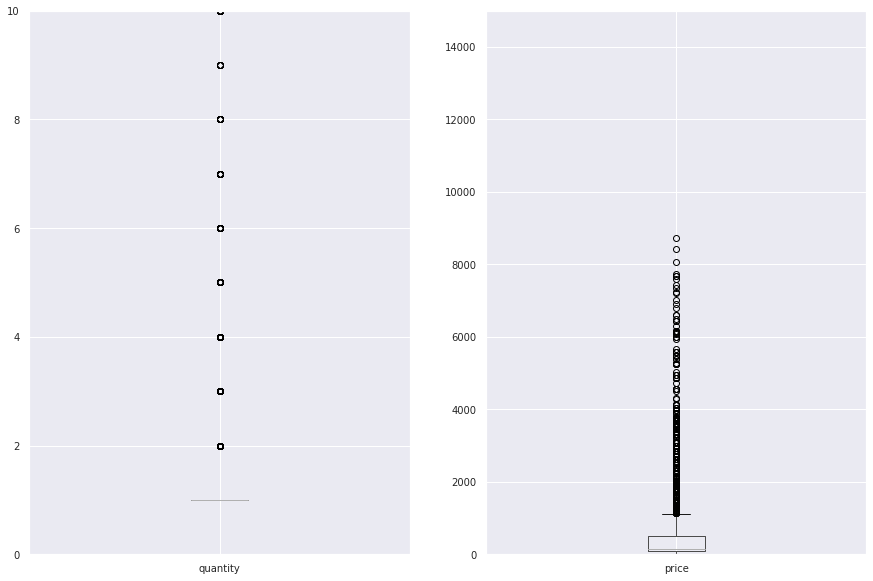

In [42]:
rows = 1
cols = 2
fig, axes = plt.subplots(rows, cols)
column_list = ['quantity', 'price']
ylims = [10, 15000]
count = 0
for c in range(cols):
    ax = data.boxplot(column=column_list[count], ax=axes[c], fontsize=10)
    ax.set_ylim([0, ylims[count]])
    count += 1

In [41]:
print(data[data['price']==data['price'].max()])
data = data.drop(3755)

                    date                           customer_id  order_id  \
3755 2019-07-29 17:00:00  0d87f4ae-465a-4fac-81e6-5d629761783e     72139   

                                                product  quantity  price  \
3755  сушилка уличная leifheit 85210 linomatic v 400...         1  14917   

      hour  weekday product_category  total_price  total     fav_category  
3755    17        0  стирка и уборка        14917  14917  стирка и уборка  


Заказ с аномально дорогим товаром лучше удалить по той же причине.

In [43]:
print(np.percentile(data['quantity'], 95))
print(np.percentile(data['quantity'], 97))
print(np.percentile(data['quantity'], 99))

7.0
11.0
30.0


Клиентов, у которых больше 30 единиц товара одного наименования, лучше рассматривать как оптовых.

In [44]:
category_quantity = data.groupby('product_category')['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)
category_quantity

,product_category,quantity
5,растения и семена,3321
2,декор,2369
9,хранение и порядок,1668
4,кухня и бытовая техника,1160
8,товары для ремонта,1022
6,стирка и уборка,883
1,ванная,448
3,ковры и напольные покрытия,189
7,текстиль для дома,170
0,балкон и сад,131


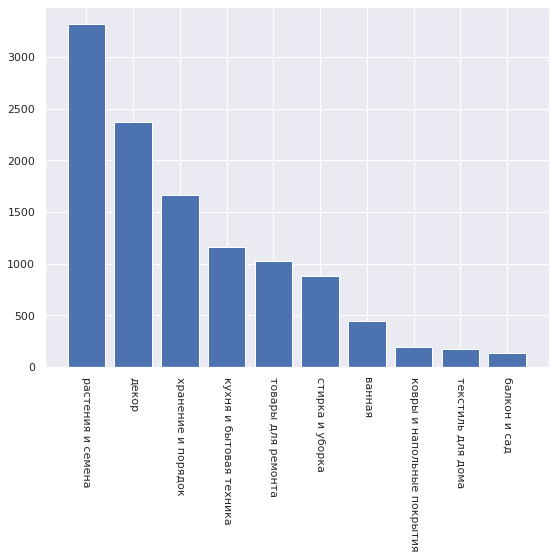

In [45]:
#график, который показывает, сколько раз категория встречалась в заказах

fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0,0,1,1])

ax.bar(category_quantity['product_category'], category_quantity['quantity'])
plt.xticks(rotation=270)
plt.rcParams.update({'font.size': 10})
plt.show()

In [46]:
#помотрим, какие категории принесли больше всего выручки
category_price = data.groupby('product_category')['total_price'].sum().reset_index().sort_values(by='total_price', ascending=False)
category_price

,product_category,total_price
9,хранение и порядок,969920
6,стирка и уборка,644813
5,растения и семена,433420
4,кухня и бытовая техника,260639
7,текстиль для дома,195976
8,товары для ремонта,179325
1,ванная,157900
3,ковры и напольные покрытия,127992
2,декор,121460
0,балкон и сад,32682


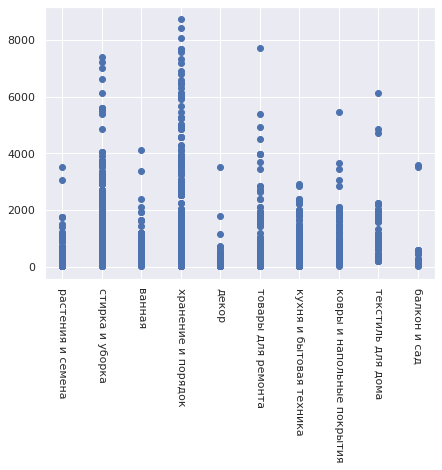

In [47]:
#scatter plot для зависимости цены от категории 

fig = plt.figure(figsize=(7, 5))
plt.scatter(data['product_category'], data['price'])
plt.xticks(rotation=270)
plt.show()

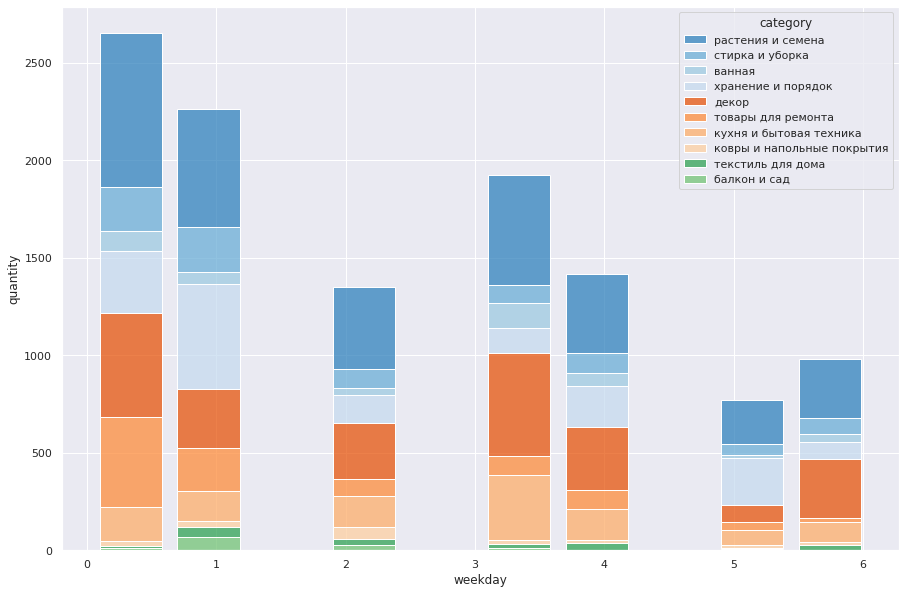

In [48]:
#stacked bar plot по дням недели и количеству товаров по категориям
# Put data in long format in a dataframe.
table = pd.DataFrame({
    'category': data['product_category'],
    'weekday': data['weekday'],
    'quantity': data['quantity']
})

# One liner to create a stacked bar chart.
ax = sns.histplot(table, x='weekday', hue='category', weights='quantity',
             multiple='stack', palette='tab20c', shrink=0.8)
ax.set_ylabel('quantity')
sns.set(rc={'figure.figsize':(15,10)})
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

В разные дни недели отличается количество купленных товаров как в общем, так и по категориям. Больше всего покупок совершено в понедельник, в этот день покупают больше всего товаров из категории "растения и семена". "Растения и семена" покупают больше в будние, чем в выходные. Во вторник купили больше всего товаров категории "хранение и порядок". Вообще в выходные покупали меньше, чем в будние дни. Можно заметить ещё, например, что по субботам не покупали товары из категории "балкон и сад", может быть, те, кому они нужны, в этот день уже в саду.  

### Сегментация покупателей на основе истории их покупок

Теперь мы можем сегментировать покупателей, проще всего это сделать по наиболее часто встречающейся в их заказах категории товаров.

In [49]:
category_data = pd.pivot_table(data,
               index="customer_id", columns= "product_category",
               values="quantity",
               aggfunc=sum,
               fill_value=0).reset_index()

category_data.dtypes

category_data['любимая категория'] = category_data[['балкон и сад', 'ванная', 'декор', 'ковры и напольные покрытия', 'кухня и бытовая техника', 
                                                    'растения и семена', 'стирка и уборка', 'текстиль для дома', 'товары для ремонта',
                                                    'хранение и порядок']].apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)

In [50]:
top_category_df = category_data[['customer_id', 'любимая категория']]
new_data = top_category_df.groupby('любимая категория')['customer_id'].count().reset_index().sort_values('customer_id', ascending=False)
new_data

,любимая категория,customer_id
5,растения и семена,591
6,стирка и уборка,413
9,хранение и порядок,409
4,кухня и бытовая техника,227
2,декор,176
1,ванная,153
8,товары для ремонта,112
3,ковры и напольные покрытия,86
7,текстиль для дома,46
0,балкон и сад,16


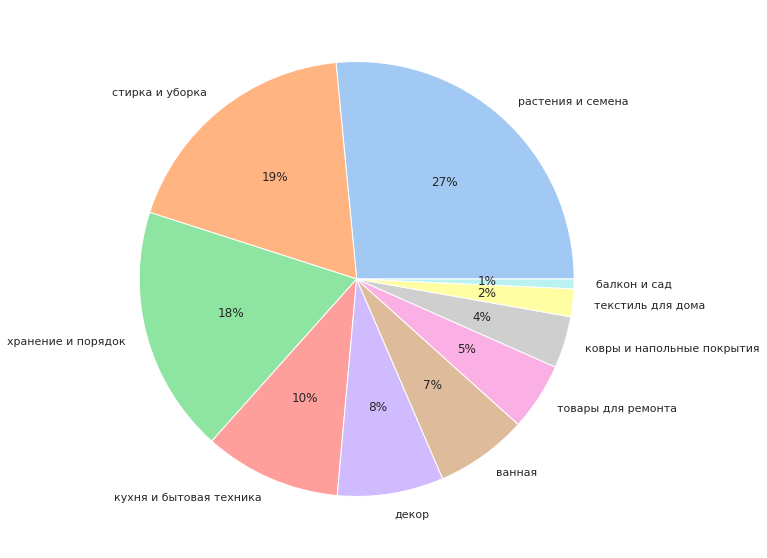

In [51]:
#отобразим результаты на pie chart

df = new_data['customer_id']
labels = new_data['любимая категория']
colors = sns.color_palette('pastel')
plt.pie(df, labels=labels,colors = colors, autopct = '%0.0f%%')
plt.show()

Посмотрим, как изменится картина, если учитывать разделение на обычных покупателей и оптовых. 

In [64]:
category_data_retail = pd.pivot_table(data[data['quantity']<30],
               index="customer_id", columns= "product_category",
               values="quantity",
               aggfunc=sum,
               fill_value=0).reset_index()

category_data_retail['любимая категория'] = category_data_retail[['балкон и сад', 'ванная', 'декор', 'ковры и напольные покрытия', 'кухня и бытовая техника', 
                                                    'растения и семена', 'стирка и уборка', 'текстиль для дома', 'товары для ремонта',
                                                    'хранение и порядок']].apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)

top_category_retail = category_data_retail[['customer_id', 'любимая категория']]
retail_data = top_category_retail.groupby('любимая категория')['customer_id'].count().reset_index().sort_values('customer_id', ascending=False)
retail_data

,любимая категория,customer_id
5,растения и семена,589
6,стирка и уборка,412
9,хранение и порядок,400
4,кухня и бытовая техника,222
2,декор,159
1,ванная,152
8,товары для ремонта,104
3,ковры и напольные покрытия,86
7,текстиль для дома,47
0,балкон и сад,15


In [66]:
category_data_wholesale = pd.pivot_table(data[data['quantity']>=30],
               index="customer_id", columns= "product_category",
               values="quantity",
               aggfunc=sum,
               fill_value=0).reset_index()

category_data_wholesale['любимая категория'] = category_data_wholesale[['балкон и сад', 'ванная', 'декор', 'кухня и бытовая техника', 
                                                    'растения и семена', 'стирка и уборка', 'товары для ремонта',
                                                    'хранение и порядок']].apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=1)

top_category_wholesale = category_data_wholesale[['customer_id', 'любимая категория']]
wholesale_data = top_category_wholesale.groupby('любимая категория')['customer_id'].count().reset_index().sort_values('customer_id', ascending=False)
wholesale_data

,любимая категория,customer_id
2,декор,18
6,товары для ремонта,9
7,хранение и порядок,9
3,кухня и бытовая техника,7
4,растения и семена,2
5,стирка и уборка,2
0,балкон и сад,1
1,ванная,1


Оптом закупают в основном декор и товары для ремонта.

### Формулировка и проверка статистических гипотез

In [52]:
data.groupby('product_category')['price'].mean().reset_index().sort_values(by='price', ascending=False)

,product_category,price
9,хранение и порядок,1464.779468
7,текстиль для дома,1257.750000
6,стирка и уборка,1081.743295
8,товары для ремонта,922.092857
3,ковры и напольные покрытия,901.157407
1,ванная,575.985075
0,балкон и сад,518.705882
4,кухня и бытовая техника,413.434783
5,растения и семена,144.408116
2,декор,103.240602


Ранее мы выяснили, что больше всего выручки принесла категория "Хранение и порядок", а самая популярная категория у покупателей - "Растения и семена". Проверим гипотезу о том, что между разными сегментами покупателей - теми, кто чаще выбирает товары категории "Хранение и порядок" и теми, кто чаще покупает из категории "Растения и семена" имеется статистически значимая разница в средних чеках (так мы узнаем, с чем связана разница в суммарной выручке, со средним чеком или например с частотой совершения покупок). 
Сформулируем нулевую и альтернативную гипотезы:

    H0 - между группами нет статистически значимых различий в среднем чеке
    H1 - средний чек у группы, которая покупает "Растения и семена", ниже.

<AxesSubplot:xlabel='total', ylabel='Density'>

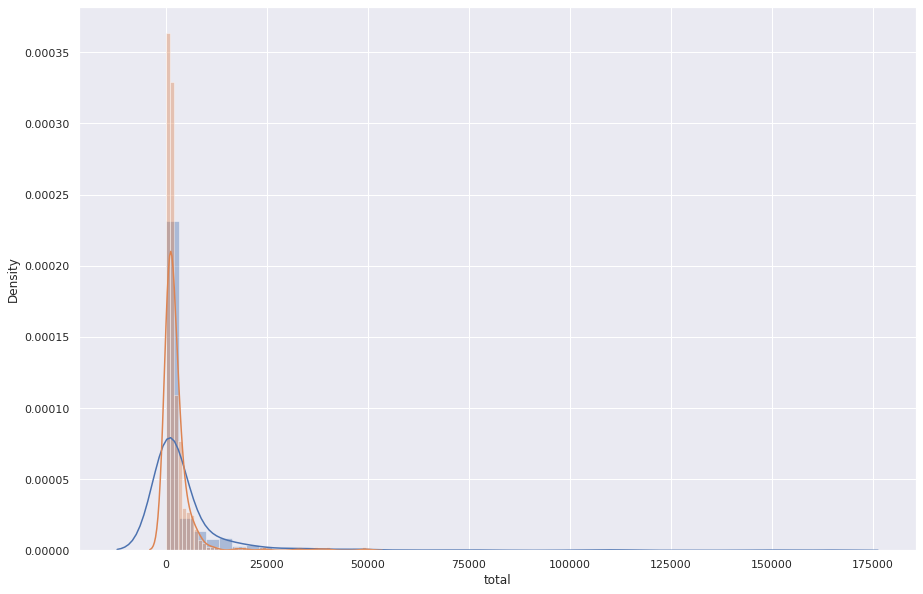

In [53]:
data = data.merge(top_category_df, on='customer_id', how='left')
data = data.rename(columns={'любимая категория': 'fav_category'})
test_data = data.query("fav_category=='растения и семена' | fav_category=='хранение и порядок'")


# разделение на группы
plant = test_data.query("fav_category=='растения и семена'")
tidy = test_data.query("fav_category=='хранение и порядок'") 

plant_lovers = plant.pivot_table(index='customer_id', values='total', aggfunc='sum').reset_index()

tidy_enjoyers = tidy.pivot_table(index='customer_id', values='total', aggfunc='sum').reset_index()

#проверка нормальности распределения
sns.distplot(plant_lovers['total'])
sns.distplot(tidy_enjoyers['total'])

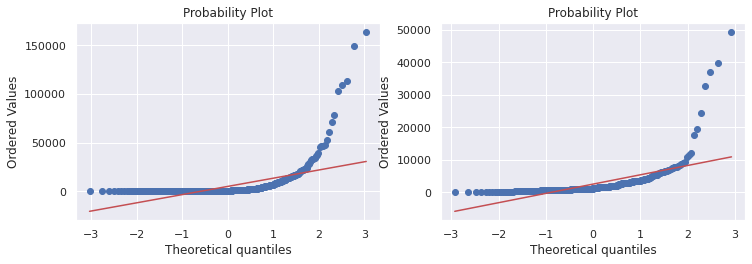

In [54]:
from scipy import stats as st

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(plant_lovers['total'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(tidy_enjoyers['total'], dist="norm", plot=plt)
plt.show()

In [60]:
# т.к. совкупности распределены не нормально, применим непараметрический (односторонний) тест

alpha = 0.05
    
results = st.mannwhitneyu(plant_lovers['total'], tidy_enjoyers['total'], alternative='less')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")      

p-значение:  5.025063727975845e-12
Отвергаем нулевую гипотезу


По результатам теста при заданном уровне альфа есть основания отвергнуть нулевую гипотезу, значит, средний чек у тех, кто больше всего покупает "растения и семена", выше. 

Также мы видели, что в разные дни недели покупают разное количество товаров. Наибольшее количество покупок совершают во вторник, наименьшее - в субботу. Проверим, отличается ли средний чек в выходные и будние дни.
Сформулируем нулевую и альтернативную гипотезы:

    H0 - между группами нет статистически значимых различий в среднем чеке
    H1 - средний чек в заказах, сделанных в будние дни, ниже. 
  

<AxesSubplot:xlabel='total', ylabel='Density'>

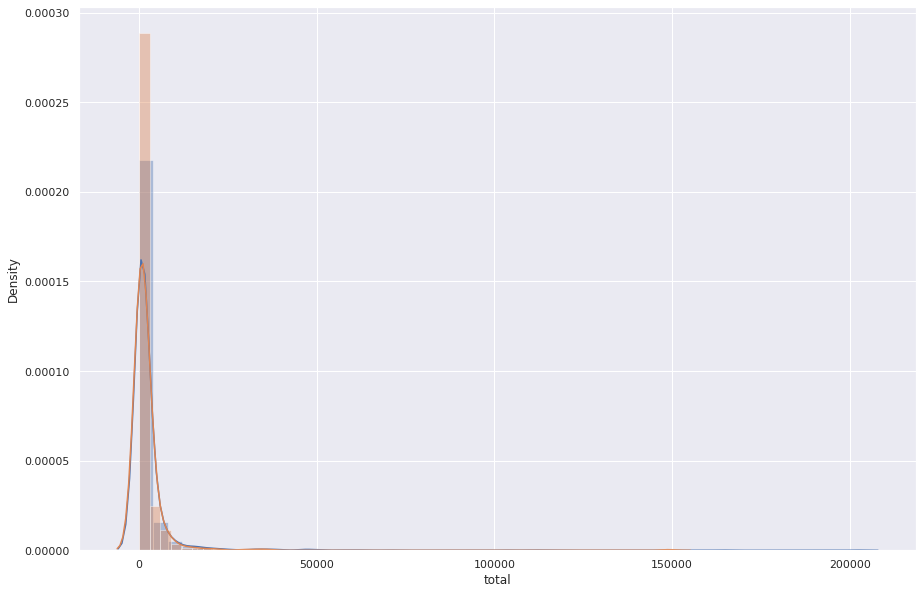

In [55]:
# разделение на группы
week = data.query("0<=weekday<=4")
end = data.query("5<=weekday<=6")

week_orders = week.pivot_table(index='order_id', values='total', aggfunc='sum').reset_index()

end_orders = end.pivot_table(index='order_id', values='total', aggfunc='sum').reset_index()

#проверка нормальности распределения
sns.distplot(week_orders['total'])
sns.distplot(end_orders['total'])

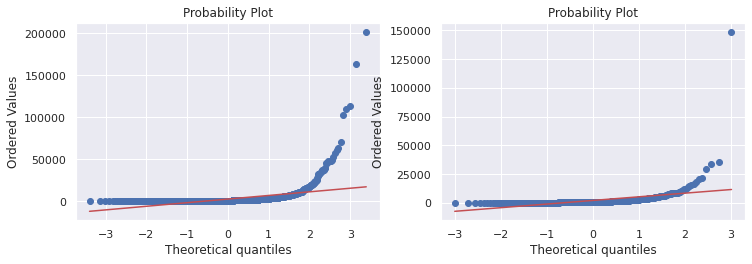

In [56]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(week_orders['total'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(end_orders['total'], dist="norm", plot=plt)
plt.show()

In [58]:
# проводим непараметрическй односторонний тест

results = st.mannwhitneyu(week_orders['total'], end_orders['total'], alternative='less')
print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")    

p-значение:  0.9364511004844345
Не получилось отвергнуть нулевую гипотезу


По результатам теста при заданном уровне альфа нет оснований отвергать нулевую гипотезу, средний чек в будние ниже, чем в выходные.

<div class="alert alert-success">
<b>👍 Успех:</b> Гипотезы сформулированы и проверены
</div>

### Выводы, рекомендации

На этапе преодработки в данных не было обнаружено аномалий, данные полные, без выбросов, был удалены некоторые строки, которые предположительно были дубликатами, но они составили меньше 1% от всего датасета. Также добавленно несколько новых признаков - день недели, в который совершена покупка, сумма заказа и категория продукта (каждому продукту присвоена одна из 10 категорий с помощью словаря с регулярными выражениями). 

В ходе EDA обнаружилось, что среднее количество товаров одного наименования в заказе - 2-3 штуки, а больше 30 единиц одного товара встречается только в 1% всех записей, поэтому покупателей, у которых встречается более 30 товаров одного нааименования, лучше рассматривать как оптовых и продумать для них отдельную маркетинговую стратегию. Чаще всего в заказах встречалась категория "растения и семена", реже всего - "балкон и сад" и "текстиль для дома". При этом больше всего выручки принесли категории "хранение и порядок" и "стирка и уборка", а "растения и семена" только на третьем месте. Анализ количества покупок по дням недели показал, что в будние покупают больше, чем в выходные, и в выходные практически не покупают товары для сада.

Выполнена сегментация клиентов на основе того, какая категория чаще всего встречалась в их заказах. В соответствии с этим можно сформировать персонализированные предложения, например, посмотреть, какой самый популярный товар в каждой категории и предлагать его тем, у кого эта категория на определена как любимая, или предлагать товары из смежных категорий. У розничных покупателей чаще всего оказывалась любимой категория "растения и семена", а у оптовых - "декор". 

Было сформулировано две гипотезы: 1. средний чек у тех, кто чаще всего покупает товары категории "растения и семена", ниже, чем у тех, кто покупает товары категории "хранение и порядок", 2. средний чек в заказах, сделанных в будние дни, ниже, чем в заказах, сделанных в выходные. Для проверки гипотез выполено разбиение в первом случае пользователей, а во втором - заказов на группы и проверка распределения на нормальность. Т.к. распределение оказалось не нормальным, в обоих случаях проведён непараметрический односторонний тест. При уровне значимости a = .05 гипотеза о равенстве средних чеков в первом случае была отвергнута, средний чек у тех, кто покупат "растения и семена", оказался выше, а вторая гипотеза подтвердилась. 